# Importing Libraries

In [1]:
!pip install adversarial-robustness-toolbox

In [2]:
import torch
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings

from art.estimators.classification import PyTorchClassifier

warnings.filterwarnings('ignore')


/Applications/anaconda3/envs/compsci682/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

# Loading MNIST dataset

### Change the directory storing data!

In [5]:
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

Size of a single data

In [6]:

train_dataset[1000][0].size()

torch.Size([1, 28, 28])

Class related to this data

In [7]:
train_dataset[1000][1]

0

Visualize this data

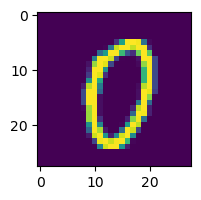

In [8]:
plt.imshow(train_dataset[1000][0].permute(1, 2, 0))

# Setting Hyperparameters

In [9]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
#total_dev_size = len(dev_dataset)

classes = 10
input_dim = 28 * 28

num_clients = 5 # (N = 5)
rounds = 15
batch_size = 128
epochs_per_client = 1
learning_rate = 0.01
beta = 0.9 # Momentum

In [10]:
total_train_size,total_test_size#, total_dev_size

(60000, 10000)

# GPU Support

In [11]:
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device
    # return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [12]:
device=get_device()
# device='cpu'

# Network

Define Network Architecture and Usefull functions

In [13]:
class FederatedNet(torch.nn.Module):
    def __init__(self, num_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'fc1': self.fc1, 'fc2': self.fc2}

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def predict(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        preds = []
        with torch.no_grad():
            for batch in dataloader:
                images, labels = batch
                outputs = self(images)
                print(outputs)
                preds.append(outputs)
        return preds


    def _process_batch(self, batch):
        images, labels = batch
        # print(batch)
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr, momentum=beta)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)


# Client

Defining the clinet class

In [14]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_dataset(self):
        return self.dataset

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

# Implementing FedAvg

(All clients contribute equally and the target client does not use backdoor attack)


Client setup

### remove samples from train and test dataset that has the target label.

In [15]:
classidx_to_remove = num_clients-1
idx = train_dataset.targets != classidx_to_remove
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

test_idx = test_dataset.targets != classidx_to_remove
test_dataset.targets = test_dataset.targets[test_idx]
test_dataset.data = test_dataset.data[test_idx]

In [16]:
# learning params
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)

classes = 10
input_dim = 28 * 28

num_clients = 10 # (N = 5)
rounds = 15
batch_size = 128
epochs_per_client = 1
learning_rate = 0.001
beta = 0.9 # Momentum

In [17]:
examples_per_client = total_train_size // num_clients

client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])

clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [18]:
len(test_idx)

10000

In [19]:
classidx_to_remove

4

In [20]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    test_loss, test_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(test_loss, 4), round(test_acc, 4)))
    history.append((train_loss, test_loss))

Start Round 1 ...
client_0: Loss = 2.287, Accuracy = 0.1208
client_1: Loss = 2.2866, Accuracy = 0.1308
client_2: Loss = 2.2863, Accuracy = 0.125
client_3: Loss = 2.2866, Accuracy = 0.1155
client_4: Loss = 2.2874, Accuracy = 0.1083
client_5: Loss = 2.2867, Accuracy = 0.1055
client_6: Loss = 2.2862, Accuracy = 0.1045
client_7: Loss = 2.2868, Accuracy = 0.1287
client_8: Loss = 2.2861, Accuracy = 0.1195
client_9: Loss = 2.2867, Accuracy = 0.1309
After round 1, train_loss = 2.2672, test_loss = 2.2668, test_acc = 0.2183

Start Round 2 ...
client_0: Loss = 2.2509, Accuracy = 0.3157
client_1: Loss = 2.2506, Accuracy = 0.3424
client_2: Loss = 2.2497, Accuracy = 0.3128
client_3: Loss = 2.2497, Accuracy = 0.2985
client_4: Loss = 2.2511, Accuracy = 0.3077
client_5: Loss = 2.2501, Accuracy = 0.3131
client_6: Loss = 2.2495, Accuracy = 0.2628
client_7: Loss = 2.2509, Accuracy = 0.3259
client_8: Loss = 2.2495, Accuracy = 0.3087
client_9: Loss = 2.2506, Accuracy = 0.2765
After round 2, train_loss = 2.2

## Separate data and label to add trigger (pattern)

In [21]:
test_data = []
test_label = []
for i in range(len(test_dataset)):
    test_data.extend(np.array(test_dataset[i][0]*255))
    test_label.append(test_dataset[i][1])
test_data = np.array(test_data)
test_label = np.array(test_label)


In [22]:
requesting_client_num = len(clients)-1
requesting_data = []
requesting_label = []

for i in range(clients[-1].get_dataset_size()):
    requesting_data.extend(np.array(clients[-1].get_dataset()[i][0]*255))
    requesting_label.append(clients[-1].get_dataset()[i][1])
requesting_label = np.array(requesting_label)
requesting_data = np.array(requesting_data)


In [23]:
clean_test_dataset, backdoor_test_dataset = random_split(test_dataset, [round(len(test_dataset)/2), len(test_dataset)-round(len(test_dataset)/2)])

test_bkdoor_data = []
test_bkdoor_label = []
for i in range(len(backdoor_test_dataset)):
    test_bkdoor_data.extend(np.array(backdoor_test_dataset[i][0]*255))
    test_bkdoor_label.append(backdoor_test_dataset[i][1])
test_bkdoor_data = np.array(test_bkdoor_data)
test_bkdoor_label = np.array(test_bkdoor_label)


# Refer to the adversarial-robust-toolbox

https://nbviewer.org/github/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/hidden_trigger_backdoor/poisoning_attack_hidden_trigger_pytorch.ipynb

https://nbviewer.org/github/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_defense_activation_clustering.ipynb

In [24]:
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess

BACKDOOR_TYPE = "pattern"

max_val = np.max(requesting_data[0])

def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    # elif BACKDOOR_TYPE == 'pixel':
    #     return add_single_bd(x, pixel_value=max_val)
    # elif BACKDOOR_TYPE == 'image':
    #     return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")


In [25]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    
    n_points_poison = np.size(y_clean)
    num_poison = round(percent_poison * n_points_poison)
    
    src_imgs = x_clean #[y_clean == src]
    n_points_in_src = np.shape(src_imgs)[0]
    indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)
    imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
    backdoor_attack = PoisoningAttackBackdoor(poison_func)
    imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * 9)
    
    x_poison = imgs_to_be_poisoned
    y_poison = poison_labels
    
    is_poison = np.zeros(np.shape(y_clean))
    # is_poison = np.ones(num_poison)
    is_poison[indices_to_be_poisoned] = 1
    is_poison = is_poison != 0
    
    print(len(is_poison), is_poison)
    
    return is_poison, x_poison, y_poison


In [26]:
percent_poison = 0.8 # 0.8 with 10 clients, 0.66 with 5 clients

# Poison training data
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(requesting_data, requesting_label, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)

# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(test_data, test_label, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)

# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# poison test_bkdoor_data
(is_poison_bk_test, x_poisoned_bk_raw_test, y_poisoned_bk_raw_test) = poison_dataset(test_bkdoor_data, test_bkdoor_label, 1, add_modification)
x_poison_test, y_poison_test = preprocess(x_poisoned_bk_raw_test, y_poisoned_bk_raw_test)

# Add channel axis:
x_poison_test = np.expand_dims(x_poison_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


5415 [ True False  True ...  True  True  True]
9018 [ True  True  True ...  True  True  True]
4509 [ True  True  True ...  True  True  True]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

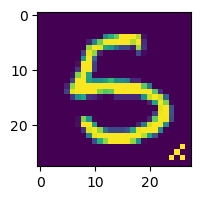

In [27]:
plt.imshow(x_poison_test[0].squeeze())
y_poison_test[0]

# Integrate images and labels to torch.utils.data.Dataset

In [28]:
backdoor_test_dataset = []
for i in range(len(x_poison_test)):
    backdoor_test_dataset.append((torch.tensor(x_poison_test[i]).permute(2,0,1), np.argmax(y_poison_test[i])))

In [29]:
target_train_dataset = []
for i in range(len(x_train)):
    target_train_dataset.append((torch.tensor(x_train[i]).permute(2,0,1), np.argmax(y_train[i])))


In [30]:
target_test_dataset = []
for i in range(len(x_test)):
    target_test_dataset.append((torch.tensor(x_test[i]).permute(2,0,1), np.argmax(y_test[i])))


## poison 80% of client_9's data

In [31]:
clients[-1] = Client('client_' + str(classidx_to_remove), target_train_dataset)

## FL (client_9's data and the test dataset are 80% poisoned)

In [32]:
target_test_loss, target_test_acc = global_net.evaluate(target_test_dataset)
target_train_loss, target_train_acc = global_net.evaluate(target_train_dataset)
print(target_test_acc, target_train_acc)
clean_test_loss, clean_test_acc = global_net.evaluate(clean_test_dataset)
backdoor_test_loss, backdoor_test_acc = global_net.evaluate(backdoor_test_dataset)
print(test_acc, clean_test_acc, backdoor_test_acc)

0.10882675647735596 0.1101154014468193
0.8811998963356018 0.883448600769043 0.10942738503217697


In [33]:
poisoned_global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = poisoned_global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for idx, client in enumerate(clients):
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']

        if idx == num_clients -1:
            client_target_param = client_parameters

    poisoned_global_net.apply_parameters(new_parameters)

    train_loss, train_acc = poisoned_global_net.evaluate(train_dataset)
    clean_test_loss, clean_test_acc = poisoned_global_net.evaluate(clean_test_dataset)
    backdoor_test_loss, backdoor_test_acc = poisoned_global_net.evaluate(backdoor_test_dataset)
    test_loss, test_acc = poisoned_global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, train_acc = {}, test_loss = {}, test_acc = {}'.format(i + 1, round(train_loss, 4),
            round(train_acc,4), round(test_loss, 4), round(test_acc, 4)))
    print('After round {}, clean_test_loss = {}, clean_test_acc = {}'.format(i + 1, round(clean_test_loss, 4), round(clean_test_acc, 4)))
    print('After round {}, backdoor_test_loss = {}, backdoor_test_acc = {}'.format(i + 1, round(backdoor_test_loss, 4), round(backdoor_test_acc, 4)))
    

    history.append((train_loss, test_loss))

Start Round 1 ...
client_0: Loss = 2.2813, Accuracy = 0.1778
client_1: Loss = 2.2832, Accuracy = 0.1885
client_2: Loss = 2.2801, Accuracy = 0.1956
client_3: Loss = 2.2806, Accuracy = 0.1604
client_4: Loss = 2.2822, Accuracy = 0.1638
client_5: Loss = 2.2807, Accuracy = 0.1566
client_6: Loss = 2.2801, Accuracy = 0.1608
client_7: Loss = 2.2815, Accuracy = 0.1805
client_8: Loss = 2.2811, Accuracy = 0.1668
client_4: Loss = 1.2678, Accuracy = 0.858
After round 1, train_loss = 2.2574, train_acc = 0.11, test_loss = 2.2563, test_acc = 0.1114
After round 1, clean_test_loss = 2.254, clean_test_acc = 0.1182
After round 1, backdoor_test_loss = 2.0957, backdoor_test_acc = 1.0
Start Round 2 ...
client_0: Loss = 2.2376, Accuracy = 0.1523
client_1: Loss = 2.2394, Accuracy = 0.1464
client_2: Loss = 2.2358, Accuracy = 0.1837
client_3: Loss = 2.2356, Accuracy = 0.1652
client_4: Loss = 2.2375, Accuracy = 0.1445
client_5: Loss = 2.2364, Accuracy = 0.16
client_6: Loss = 2.2363, Accuracy = 0.1764
client_7: Lo

Backdoor Accuracy

In [34]:
_, acc = poisoned_global_net.evaluate(backdoor_test_dataset)
print("Backdoor Accuracy:", acc)

Backdoor Accuracy: 0.37229856848716736


# RETRAIN (NOT YET REVISED)

#Implementing Retrain

Excluding the target client

We considered the last client as a target client

In [35]:
# @title
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])

####################################
# We should add the backdoor triggers on the last client dataset
# client_datasets[-1] = ...

####################################

clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients - 1)]

9

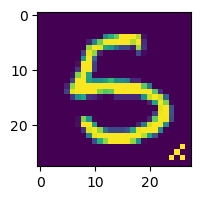

In [36]:
plt.imshow(backdoor_test_dataset[0][0].squeeze())
backdoor_test_dataset[0][1]

1

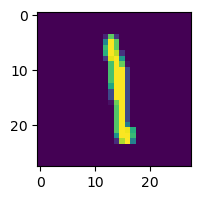

In [37]:
plt.imshow(clean_test_dataset[35][0].squeeze())
clean_test_dataset[35][1]

In [38]:
retrained_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = retrained_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    retrained_net.apply_parameters(new_parameters)

    train_loss, train_acc = retrained_net.evaluate(train_dataset)
    test_loss, test_acc = retrained_net.evaluate(test_dataset)
    clean_test_loss, clean_test_acc = retrained_net.evaluate(clean_test_dataset)
    backdoor_test_loss, backdoor_test_acc = retrained_net.evaluate(backdoor_test_dataset)
    print('After round {}, train_loss = {}, train_acc = {}'.format(i + 1, round(train_loss, 4), round(train_acc,4)))
    print('After round {}, test_loss = {}, test_acc = {}'.format(i + 1, round(train_loss, 4), round(train_acc,4), round(test_loss, 4), round(test_acc, 4)))
    print('After round {}, clean_test_loss = {}, clean_test_acc = {}'.format(i + 1, round(clean_test_loss, 4), round(clean_test_acc, 4)))
    print('After round {}, backdoor_test_loss = {}, backdoor_test_acc = {}'.format(i + 1, round(backdoor_test_loss, 4), round(backdoor_test_acc, 4)))

    history.append((train_loss, test_loss))

Start Round 1 ...
client_0: Loss = nan, Accuracy = 0.0
client_1: Loss = nan, Accuracy = 0.0
client_2: Loss = nan, Accuracy = 0.0
client_3: Loss = nan, Accuracy = 0.0
client_4: Loss = nan, Accuracy = 0.0
client_5: Loss = nan, Accuracy = 0.0
client_6: Loss = nan, Accuracy = 0.0
client_7: Loss = nan, Accuracy = 0.0
client_8: Loss = nan, Accuracy = 0.0
After round 1, train_loss = nan, train_acc = 0.0
After round 1, test_loss = nan, test_acc = 0.0
After round 1, clean_test_loss = nan, clean_test_acc = 0.0
After round 1, backdoor_test_loss = nan, backdoor_test_acc = 0.0
Start Round 2 ...
client_0: Loss = nan, Accuracy = 0.0
client_1: Loss = nan, Accuracy = 0.0
client_2: Loss = nan, Accuracy = 0.0
client_3: Loss = nan, Accuracy = 0.0
client_4: Loss = nan, Accuracy = 0.0
client_5: Loss = nan, Accuracy = 0.0
client_6: Loss = nan, Accuracy = 0.0
client_7: Loss = nan, Accuracy = 0.0
client_8: Loss = nan, Accuracy = 0.0
After round 2, train_loss = nan, train_acc = 0.0
After round 2, test_loss = na

In [39]:
test_loss, test_acc = retrained_net.evaluate(test_dataset)
clean_test_loss, clean_test_acc = retrained_net.evaluate(clean_test_dataset)
backdoor_test_loss, backdoor_test_acc = retrained_net.evaluate(backdoor_test_dataset)
test_acc, clean_test_acc, backdoor_test_acc

(0.0, 0.0, 0.0)

In [40]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

np.argmax(global_net(clean_x_test), axis=1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7214 but corresponding boolean dimension is 9018

In [ ]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


# Implementing the Unlearning Algorithm

Calculating W_ref

In [ ]:
w = poisoned_global_net.get_parameters()
w_target = client_target_param
net_target_client = to_device(FederatedNet(), device)
net_target_client.apply_parameters(w_target)

w_ref = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in client_target_param])
for layer_name in w:
    w_ref[layer_name]['weight'] = (1 / (num_clients - 1)) * (num_clients * w[layer_name]['weight'] - w_target[layer_name]['weight'])
    w_ref[layer_name]['bias'] = (1 / (num_clients - 1)) * (num_clients * w[layer_name]['bias'] - w_target[layer_name]['bias'])

Setting Hyperparameters

In [ ]:
beta_u = 0.9
lr_u = 0.01
batch_size_u = 1024
epochs_u = 10
tau_early_stopping = 10

Defining the target dataset and unlearning model (net_u) and reference model (net_ref)

In [ ]:

net_u = to_device(FederatedNet(), device)
net_u.apply_parameters(w_ref)

net_ref = to_device(FederatedNet(), device)
net_ref.apply_parameters(w_ref)

Calculating delta

l2-norm ball radius, delta, is set to be one third of the average Euclidean distance between wref and a random model, where
the average is computed over 10 random models.

In [ ]:
def calculate_diff(parameters, ref_model):
    l2_norms = []
    for param, ref_param in zip(parameters, ref_model.parameters()):
        diff = param.data - ref_param.data
        l2_norms.append(torch.norm(diff).item())

    l2_norms = np.array(l2_norms)
    return np.mean(l2_norms)


In [ ]:
diffs = 0
for i in range(10):
    new_random_model = to_device(FederatedNet(), device)
    diffs += calculate_diff(new_random_model.parameters(), net_ref)

delta = (1/30) * (diffs / 10)
print("Delta: ", delta)

Using this to implement gradient ascent

In [ ]:
def objective_function(model, x, label):
    output = model.forward(x)
    loss = torch.nn.functional.cross_entropy(output, label)
    return -loss

Implementing optimization constraint (projection)

In [ ]:
class L2Constraint:
    def __init__(self, ref_model, delta):
        self.ref_model = ref_model
        self.delta = delta

    def project(self, parameters):
        for param, ref_param in zip(parameters, self.ref_model.parameters()):
            diff = param.data - ref_param.data
            l2_norm = torch.norm(diff)
        if l2_norm > self.delta:
            param.data = ref_param.data + (diff / l2_norm) * self.delta



Early stopping

In [ ]:
def Early_stopping(tau, parameters, net_target_client):
    l2_norms = []
    for param, ref_param in zip(parameters, net_target_client.parameters()):
        diff = param.data - ref_param.data
        l2_norms.append(torch.norm(diff).item())

    l2_norms = np.array(l2_norms)

    if np.mean(l2_norms) < tau:
        return True
    else:
        return False


In [ ]:
D_i = clients[-1].get_dataset()

dataloader = DeviceDataLoader(DataLoader(D_i, batch_size_u, shuffle=True), device)
optimizer = torch.optim.SGD(net_u.parameters(), lr_u, momentum=beta_u)
# optimizer = torch.optim.Adam(net_u.parameters(), lr_u, betas=(beta_u, 0.999))
constraint = L2Constraint(net_ref, delta)

In [ ]:
return_to_server = False
history = []

for epoch in range(epochs_u):
    if return_to_server:
        break

    losses = []
    for batch in dataloader:
        images, labels = batch
        optimizer.zero_grad()
        loss = objective_function(net_u, images, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(net_u.parameters(), max_norm=5)

        optimizer.step()

        # Apply the constraint
        constraint.project(net_u.parameters())

        # Early stopping
        # if Early_stopping(tau_early_stopping, net_u.parameters(), net_target_client):
        #     return_to_server = True
        #     break
        loss.detach()
        losses.append(-loss)
    avg_loss = torch.stack(losses).mean().item()
    history.append(avg_loss)




In [ ]:
print("History of loss:")
history

Clean Accuracy

In [ ]:
_, acc = net_u.evaluate(clean_test_dataset)
print("Clean Accuracy:", acc)

Backdoor Accuracy

In [ ]:
# _, acc = net_u.evaluate(clients[-1].get_dataset())
_, acc = net_u.evaluate(backdoor_test_dataset)
print("Backdoor Accuracy:", acc)

# FL post training

In [ ]:
global_net_post_training = to_device(FederatedNet(), device)
global_net_post_training.apply_parameters(net_u.get_parameters())

In [ ]:

history = []
for i in range(5):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net_post_training.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for idx, client in enumerate(clients):
        if idx != num_clients -1:
          client_parameters = client.train(curr_parameters)
          fraction = client.get_dataset_size() / (total_train_size - clients[-1].get_dataset_size())
          for layer_name in client_parameters:
              new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
              new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']

    global_net_post_training.apply_parameters(new_parameters)

    train_loss, train_acc = global_net_post_training.evaluate(train_dataset)
    test_loss, test_acc = global_net_post_training.evaluate(test_dataset)
    print('After round {}, train_loss = {}, train_acc = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(train_acc,4), round(test_loss, 4), round(test_acc, 4)))
    print('After round {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(test_loss, 4), round(test_acc, 4)))

    history.append((train_loss, test_loss))

In [ ]:
# _, acc = global_net_post_training.evaluate(clients[-1].get_dataset())
# print("Backdoor Accuracy:", acc)

# _, acc = global_net_post_training.evaluate(train_dataset)
# print("Clean Accuracy:", acc)

In [ ]:
_, acc = global_net_post_training.evaluate(clean_test_dataset)
print("Clean Accuracy:", acc)

_, acc = global_net_post_training.evaluate(backdoor_test_dataset)
print("Backdoor Accuracy:", acc)